# Y E A S T

### 'fine replicates' and their consistency 

In [1]:
import pandas as pd
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt
import matplotlib as m

plt.rcParams["figure.dpi"] = 300

In [2]:
# basic bayexpress functions

# calculating Bayes factors for expression change
def get_BF_21(N_1, n_1, N_2, n_2):

    return (sc.betaln( u_1 + n_1, u_2 + N_1 - n_1) + sc.betaln( u_1 + n_2, u_2 + N_2 - n_2) - sc.betaln( u_1 + n_1 + n_2, u_2 + N_1 - n_1 + N_2 - n_2)) / np.log(10) 

# ratio of expression 
# calculating log fold change
def get_FC(N_1, n_1, N_2, n_2):
    rate_1 = (u_1 + n_1) / (u_2 + N_1 - n_1)
    rate_2 = (u_1 + n_2) / (u_2 + N_2 - n_2)

    return np.log2(rate_2 / rate_1)

# calculating q (following Laplace's rule of succession)
def get_q(n, N):
    return (n+1)/(N+2)

# setting the priors to flat prios
u_1 = 1
u_2 = 1


# calculating Bayes factors for consistency checks

def get_BF_k1(data):
    # this range is irrelevant if we want to do all 
    k = len(data.columns)

    evidence2 = np.full(len(data), 0)

    # iterating over j until k
    for col in data.columns[1:k]: 
        n_j = data[col]
        # print(n_j, 'n_j')
        N_j = sum(data[col])
        # print(N_j, 'N_j')
        evidence2 = evidence2 + sc.betaln(u_1 + n_j, u_2 + N_j - n_j)

    N = sum(data.iloc[:,1:k].sum(axis=0, numeric_only=True))
    n_i = data.iloc[:,1:k].sum(axis=1, numeric_only=True)

    # print(n_i, 'n_i')
    # print(N, 'N')

    evidence1 = sc.betaln( u_1 + n_i, u_2 + N - n_i)

    return (evidence2 - evidence1) / np.log(10) 


In [3]:
# exploring 'cumulative' BF

def get_cumu_BF(data):
    out_data = pd.DataFrame({})
    for k in range(3,len(data.columns)+1):

        evidence2 = np.full(len(data), 0)

        # iterating over j until k
        for col in data.columns[1:k]: 
            n_j = data[col]
            # print(n_j, 'n_j')
            N_j = sum(data[col])
            # print(N_j, 'N_j')
            evidence2 = evidence2 + sc.betaln(u_1 + n_j, u_2 + N_j - n_j)

        N = sum(data.iloc[:,1:k].sum(axis=0, numeric_only=True))
        n_i = data.iloc[:,1:k].sum(axis=1, numeric_only=True)

        # print(n_i, 'n_i')
        # print(N, 'N')

        evidence1 = sc.betaln( u_1 + n_i, u_2 + N - n_i)
        
        out_data[f'{k-1}'] = (evidence2 - evidence1) / np.log(10) 

    return out_data


### CONSISTENCY TESTS

In [4]:
WT_yeast = pd.read_csv('WT_yeast.csv', index_col=0)
Snf2_yeast = pd.read_csv('Snf2_yeast.csv', index_col=0)

display(WT_yeast)
display(Snf2_yeast)

,genes,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,15S_rRNA,2,12,31,8,21,11,2,3,7,...,0,49,9,4,11,12,1,22,12,4
1,21S_rRNA,20,76,101,99,128,74,36,32,57,...,10,274,49,30,72,58,21,159,107,70
2,HRA1,3,2,2,2,3,5,4,0,4,...,5,3,6,5,2,2,2,5,2,1
3,ICR1,75,123,107,157,98,245,119,120,119,...,85,177,137,118,113,81,142,94,187,106
4,LSR1,60,163,233,163,193,375,194,84,211,...,66,385,232,149,114,81,109,132,243,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,tY(GUA)J2,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7122,tY(GUA)M1,0,0,1,1,1,1,0,0,1,...,0,1,1,0,1,0,0,0,1,0
7123,tY(GUA)M2,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7124,tY(GUA)O,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


,genes,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,15S_rRNA,4,2,5,5,46,5,4,2,40,...,7,15,6,1,85,8,34,3,6,3
1,21S_rRNA,31,18,23,44,356,35,33,13,148,...,64,79,67,13,576,52,234,23,44,24
2,HRA1,5,1,3,1,2,1,4,4,0,...,5,5,0,2,0,1,2,2,0,1
3,ICR1,205,196,211,252,127,275,160,190,146,...,286,155,184,164,202,186,148,183,195,145
4,LSR1,210,103,159,260,298,303,96,132,263,...,250,195,153,57,742,227,227,117,224,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,tY(GUA)J2,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,2,1,1
7122,tY(GUA)M1,0,0,1,0,2,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
7123,tY(GUA)M2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7124,tY(GUA)O,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [5]:
# calculating 'cumulatative' BF_k1

WT_cumu = get_cumu_BF(WT_yeast)

display(WT_cumu)

Snf2_cumu = get_cumu_BF(Snf2_yeast)


display(Snf2_cumu)

,2,3,4,5,6,7,8,9,10,11,...,33,34,35,36,37,38,39,40,41,42
0,-4.824123,-4.912829,-8.839685,-14.117564,-17.996641,-21.086076,-24.943705,-30.693142,-36.473404,-36.748828,...,-78.392957,-79.236264,-83.873072,-87.899103,-93.755645,-99.564530,-98.737339,-102.165373,-107.111094,-111.028167
1,-0.963656,0.632576,-4.889390,-5.707717,-1.756501,-1.034256,1.474677,-3.694451,-4.328017,30.503034,...,314.603331,332.522436,337.316054,341.359343,335.890120,333.215257,356.876602,375.089399,370.679089,365.965229
2,-5.943931,-12.083265,-18.278537,-24.465218,-30.802653,-36.940374,-42.530537,-48.629171,-54.649860,-60.521649,...,-192.140921,-198.484739,-204.355581,-210.085429,-216.320230,-222.587706,-228.790003,-234.076721,-240.250222,-246.380070
3,-4.823112,-9.807353,-15.238338,-19.905392,-24.625241,-29.785183,-34.360645,-39.709611,-44.590227,-49.889550,...,-155.375929,-160.782614,-166.296698,-171.236715,-175.771447,-179.030847,-184.072077,-188.751188,-193.899154,-199.310861
4,0.108211,10.803119,9.032746,4.700363,1.487643,-3.873543,11.533645,7.137768,1.803757,6.654632,...,249.996802,253.183338,247.773924,242.971550,239.948338,250.582110,269.366427,264.188637,259.247720,257.043307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,-6.286567,-12.763830,-19.421876,-26.124338,-32.363821,-39.044382,-45.782284,-52.528131,-59.264657,-65.422555,...,-215.130801,-222.115884,-229.041179,-235.853189,-242.628019,-249.481368,-256.468048,-263.178684,-270.184691,-277.038617
7122,-6.531056,-12.675472,-19.165382,-25.559965,-32.208462,-38.822300,-45.496440,-51.930123,-58.585525,-65.225674,...,-209.970841,-216.538875,-223.000753,-229.707786,-235.891374,-242.622613,-249.440170,-256.071351,-262.651404,-269.387754
7123,-6.531056,-12.675472,-19.333519,-26.035980,-32.922786,-39.191373,-45.993039,-52.789226,-59.566314,-66.302507,...,-215.904536,-222.907910,-229.847933,-236.670440,-243.454560,-250.319009,-257.321064,-264.038923,-271.060168,-277.923892
7124,-6.531056,-13.174062,-20.012232,-26.815334,-33.841214,-39.875493,-46.740922,-53.587450,-60.405100,-67.173308,...,-217.027288,-224.048953,-230.003826,-236.826334,-243.610453,-250.474902,-257.476958,-264.194816,-271.216061,-277.030310


,2,3,4,5,6,7,8,9,10,11,...,35,36,37,38,39,40,41,42,43,44
0,-6.103991,-12.057457,-18.248233,-0.689254,-4.779452,-10.148008,-14.380417,-8.405656,-13.822875,-19.135557,...,58.990171,53.171198,50.286105,48.540940,67.204146,63.100998,59.969102,58.492922,55.074698,52.273279
1,-5.373082,-11.152096,-15.709169,164.012305,176.098447,175.473667,187.389002,199.129378,194.351127,194.767768,...,804.627349,799.728536,799.019121,811.207678,1011.496083,1014.180313,1037.861715,1054.538366,1059.645076,1068.603540
2,-5.776665,-11.988302,-18.045738,-24.279166,-30.448821,-36.302987,-42.457222,-48.388459,-54.694911,-60.979764,...,-209.316343,-214.850561,-220.739455,-226.997613,-232.939793,-239.278730,-245.600999,-251.971431,-257.999634,-264.347894
3,-4.971297,-9.804811,-14.992280,-19.330740,-24.753763,-29.744215,-34.505353,-38.882697,-44.050455,-49.311961,...,-155.746721,-161.075340,-166.370178,-170.515722,-175.754308,-181.035691,-186.357233,-191.677668,-196.533408,-201.913097
4,-0.576562,-5.754128,-6.633886,15.230201,10.031782,15.283111,17.306187,20.515392,18.416235,13.685228,...,321.437539,316.081994,316.897201,329.751911,485.680806,480.472207,476.587686,482.279438,477.098099,473.797677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,-6.404911,-13.017210,-19.762178,-26.456642,-33.341253,-39.530966,-46.347490,-53.129063,-59.979981,-66.750607,...,-230.114841,-236.079392,-242.999319,-249.784977,-256.694193,-263.577612,-270.417138,-275.356707,-281.477286,-287.490152
7122,-6.672068,-12.950527,-19.695495,-25.231652,-31.904670,-38.586324,-45.341319,-52.078137,-58.880708,-65.618429,...,-222.528536,-228.875641,-235.353807,-242.033736,-248.799687,-255.553666,-262.281139,-269.041926,-275.805506,-282.046301
7123,-6.672068,-13.449795,-20.336202,-27.102349,-34.092758,-40.946441,-47.886024,-54.757106,-61.704721,-67.404270,...,-229.953348,-236.815191,-243.748169,-250.542638,-257.463792,-264.357998,-271.206862,-278.100616,-284.993383,-291.816655
7124,-6.334297,-12.946597,-19.691564,-26.386028,-33.270640,-40.066980,-46.945034,-53.063258,-59.914177,-66.684802,...,-228.743133,-234.775721,-241.682596,-248.459444,-255.356721,-262.229353,-269.059542,-275.932839,-282.805731,-289.612759


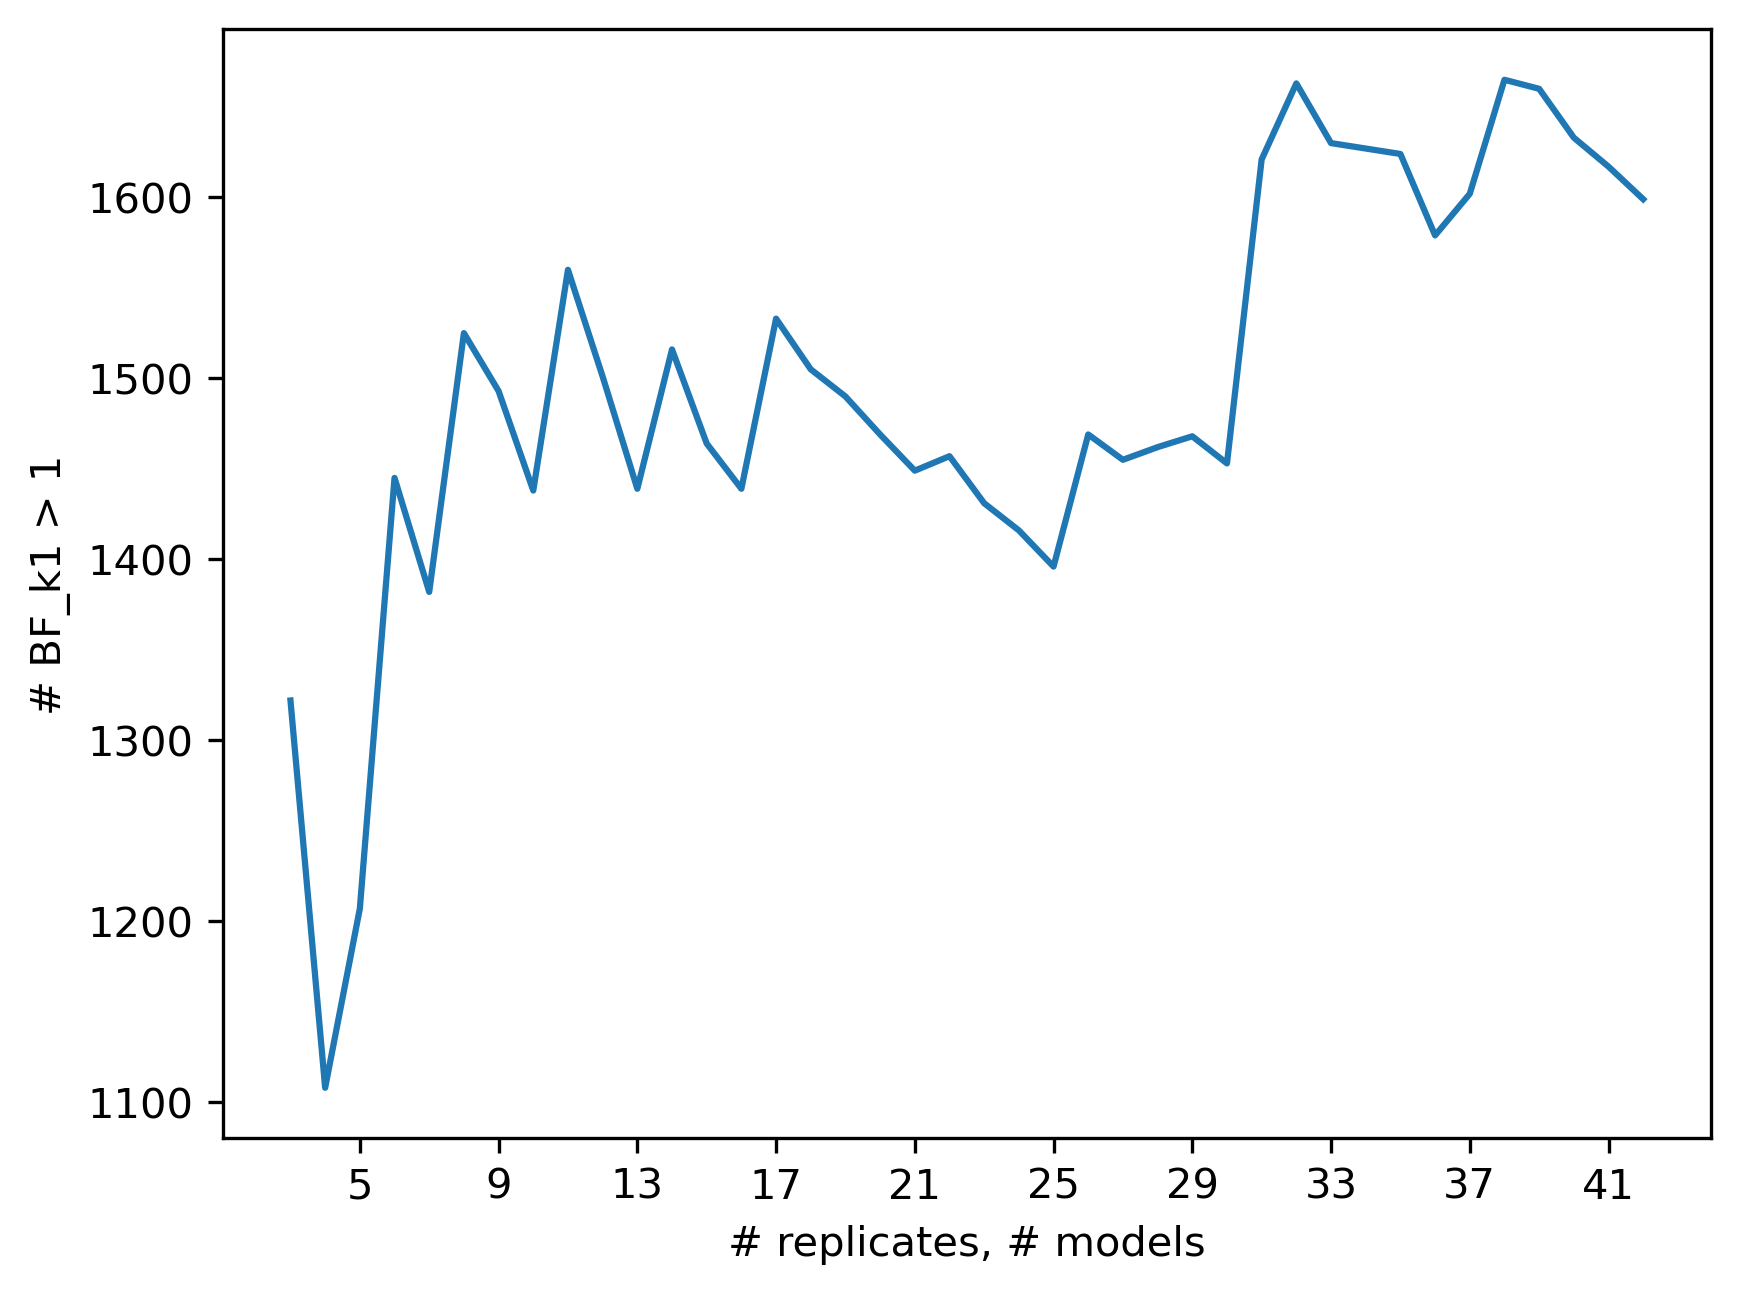

In [6]:
# this is the general idea

# finding the number of genes with BF_k1 > 1 while increasing number of reps
series = (WT_cumu.iloc[:,1:] > 1).sum()

series.plot(xlabel='# replicates, # models', ylabel='# BF_k1 > 1', xticks=range(2,len(series),4), legend=False)


plt.show()

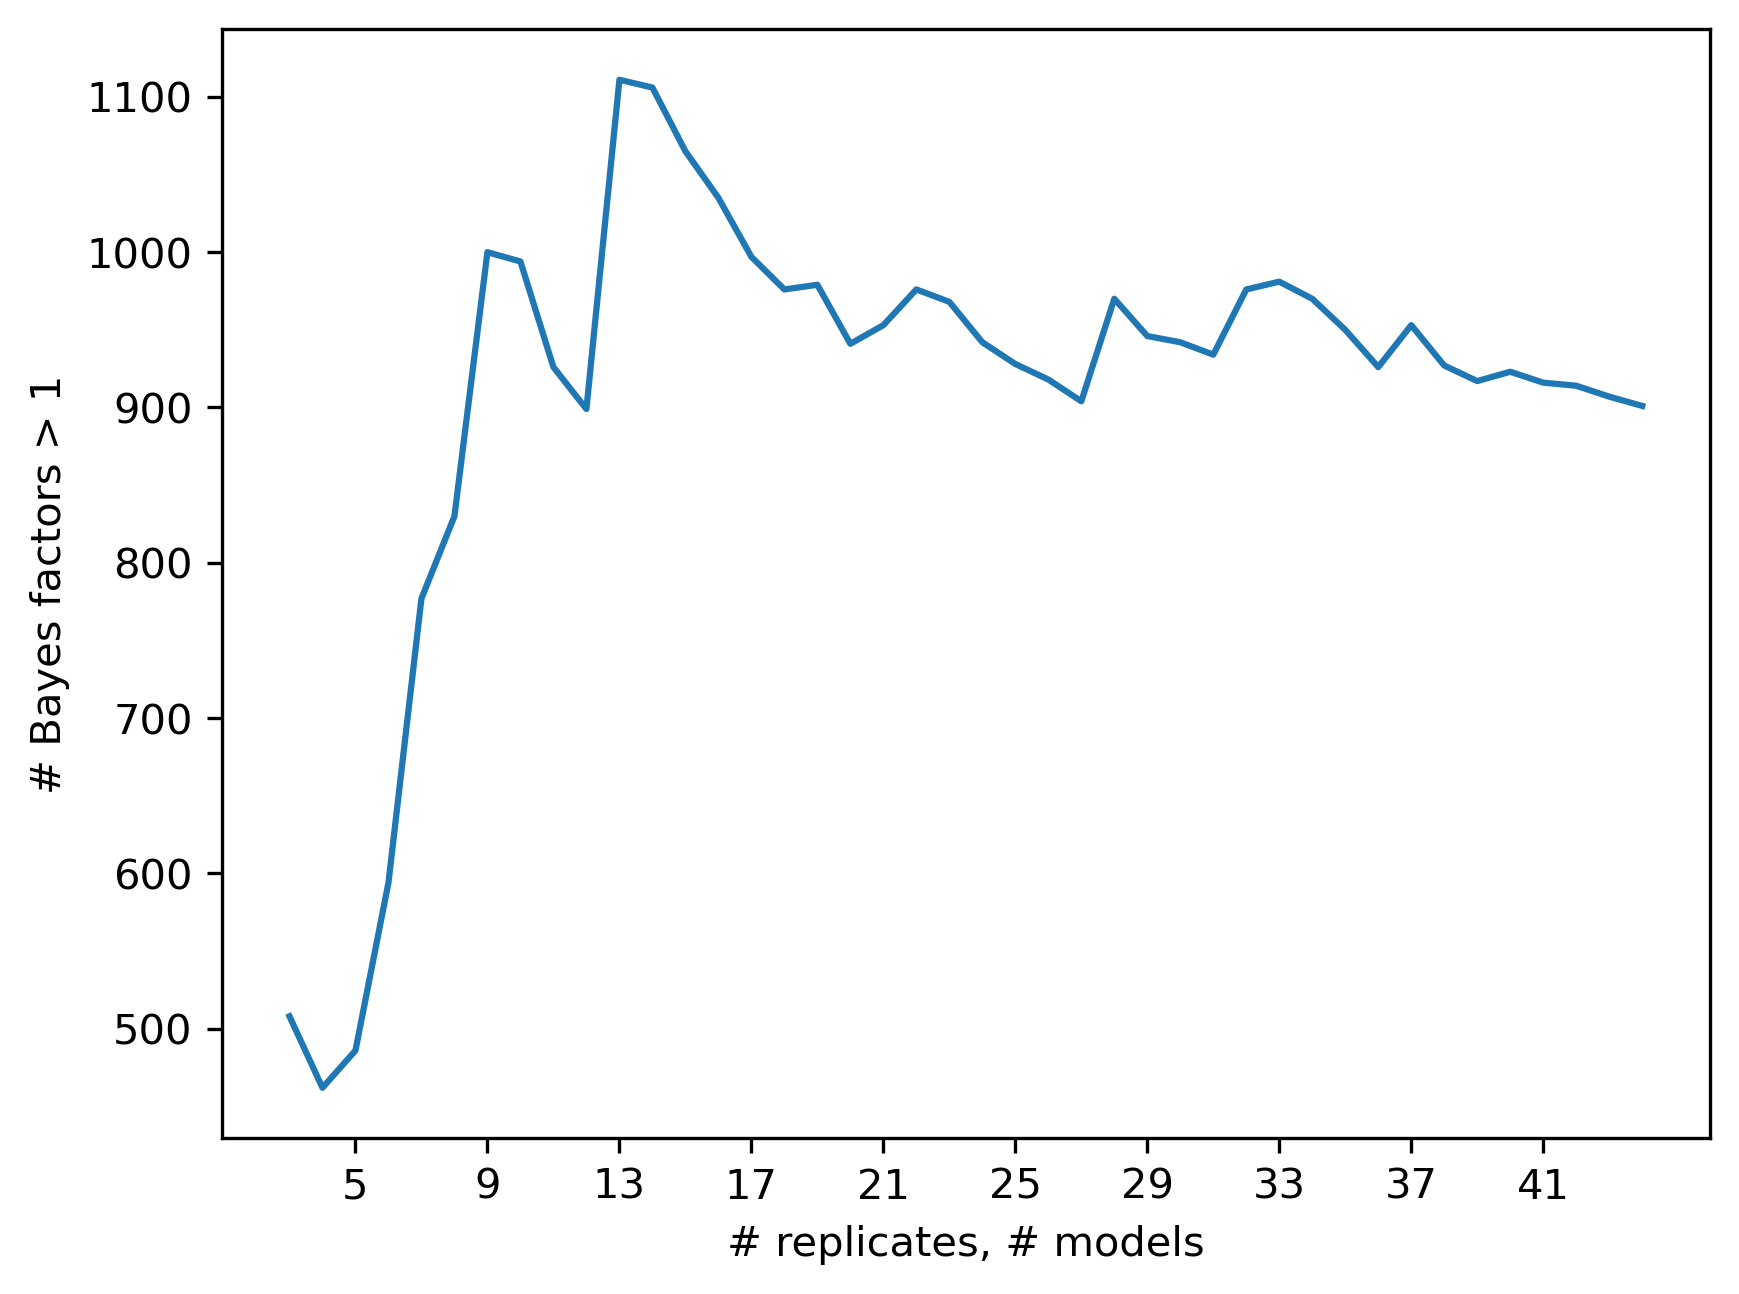

In [7]:
# this is the general idea

# finding the number of genes with BF_k1 > 1 while increasing number of reps
series = (Snf2_cumu.iloc[:,1:] > 1).sum()


series.plot(xlabel='# replicates, # models', ylabel='# Bayes factors > 1', xticks=range(2,len(series),4), legend=False)

plt.show()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2,460,1265,173,893,720,917,2052,935,1477,3008,315,483,1878,494,1329,1418,911,537,870,519
3,1156,1274,927,839,1150,1229,1769,908,945,2986,933,429,2295,1731,1436,1615,1304,976,2395,955
4,1056,1224,1217,762,1665,1220,1566,1170,1593,2548,1257,427,2070,1552,1360,1609,1252,864,2571,1153
5,1091,1113,1258,707,1554,1171,1448,1273,1385,2311,1491,356,2330,2034,1317,1841,1089,866,2662,1318
6,1262,1279,1267,1103,1493,1175,1533,1241,1990,2073,1446,1084,2191,2017,1216,2606,1037,1504,2391,1475
7,1156,1273,1209,1386,1417,1302,1530,1369,1939,1881,1390,1066,2076,2124,1222,2398,943,1430,2187,1455
8,1377,1219,1383,1339,1512,1356,1459,1489,2286,1841,1373,1034,2089,1967,1422,2244,1230,1385,2103,1462
9,1295,1188,1904,1424,1475,1307,1428,1448,2139,1749,1523,1139,1928,1947,1360,2099,1333,1760,1958,1557
10,1396,1272,1888,1410,1475,1321,1372,1488,2179,1786,1913,1045,1828,1867,1446,2048,1304,2097,1931,1518
11,1490,1209,2083,1350,1429,1305,1305,1420,2260,1713,1828,1280,1756,2052,1419,1978,1311,2098,2033,1494


<Axes: xlabel='# replicates', ylabel='# BF_k1 > 1 of 7126 genes'>

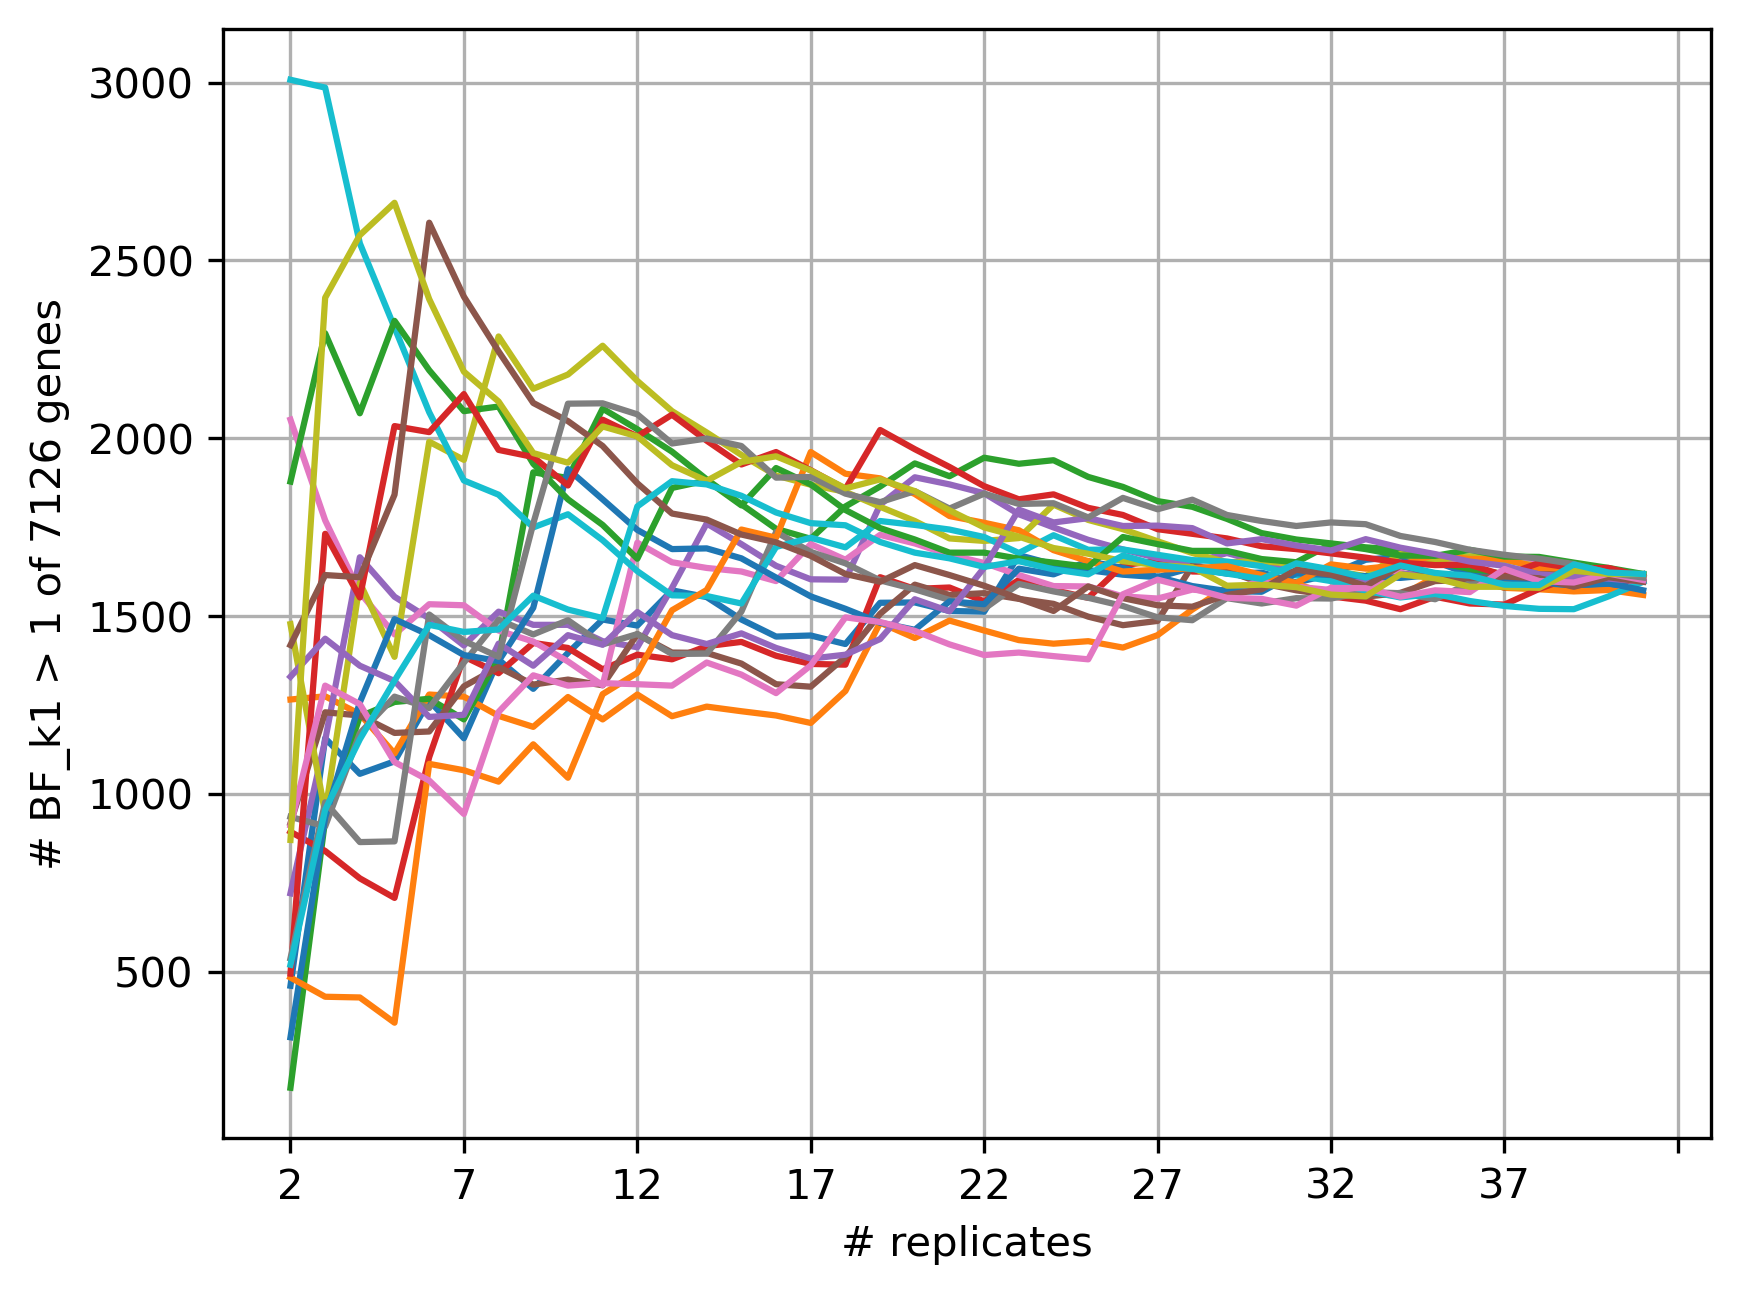

In [8]:
# then bootstrapping this idea
# 20 times for figure

WT_cons_it = pd.DataFrame({})
# let's do this with more iterations
# WT_AOTP = []

for i in range(20):

    col_order = np.array(WT_yeast.columns[1:])
    np.random.shuffle(col_order)
    # print(col_order)

    cumu_BF_k1 = get_cumu_BF(WT_yeast[col_order])
    # WT_AOTP.append(WT_yeast.loc[(cumu_BF_k1).iloc[:,-1] > 1].index)

    WT_cons_it[f'{i+1}'] = ((cumu_BF_k1) > 1).sum()

display(WT_cons_it)

display(WT_cons_it.plot(legend=False, grid=True,
                        xlabel='# replicates',
                        ylabel='# BF_k1 > 1 of 7126 genes'
                        ))

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
2,1087,480,2031,1218,1180,847,118,1864,2032,1011,...,1226,1336,770,774,474,1073,284,1712,1180,1641
3,924,603,1742,2493,1104,852,251,1415,2965,1044,...,1104,1055,571,879,723,1244,633,1124,1096,2106
4,950,1046,1831,2129,872,1455,1322,1533,2383,1855,...,1426,1356,824,1604,733,1035,1230,1562,1100,2103
5,1134,1513,1722,2428,1300,1690,1216,1411,2274,1639,...,2153,1338,985,1410,644,881,1095,1629,1108,1690
6,1439,1401,1597,2261,1320,1580,1437,1279,1938,2038,...,2126,1300,1037,1313,1759,986,1004,1516,1186,2007
7,1356,1351,1444,2138,1233,1496,1449,1200,1729,1953,...,2085,1297,1135,1213,1663,1245,979,1697,1050,2083
8,1269,1450,1451,1990,1188,1478,1441,1202,1797,1902,...,2035,1360,1093,1268,1486,1143,1183,1583,1350,1996
9,1244,1431,1444,1863,1380,1480,1456,1145,1649,1926,...,1986,1324,1021,1538,1811,1181,1230,1722,1438,1960
10,1209,1368,1370,1731,1507,1411,1408,1405,1707,1868,...,1853,1342,1154,1557,1957,1231,1211,1670,1402,2061
11,1296,1477,1495,1697,1503,1369,1415,1785,1600,1763,...,1920,1302,1173,1670,1850,1437,1268,1551,1333,1927


<Axes: xlabel='# replicates', ylabel='# BF_k1 > 1 of 7126 genes'>

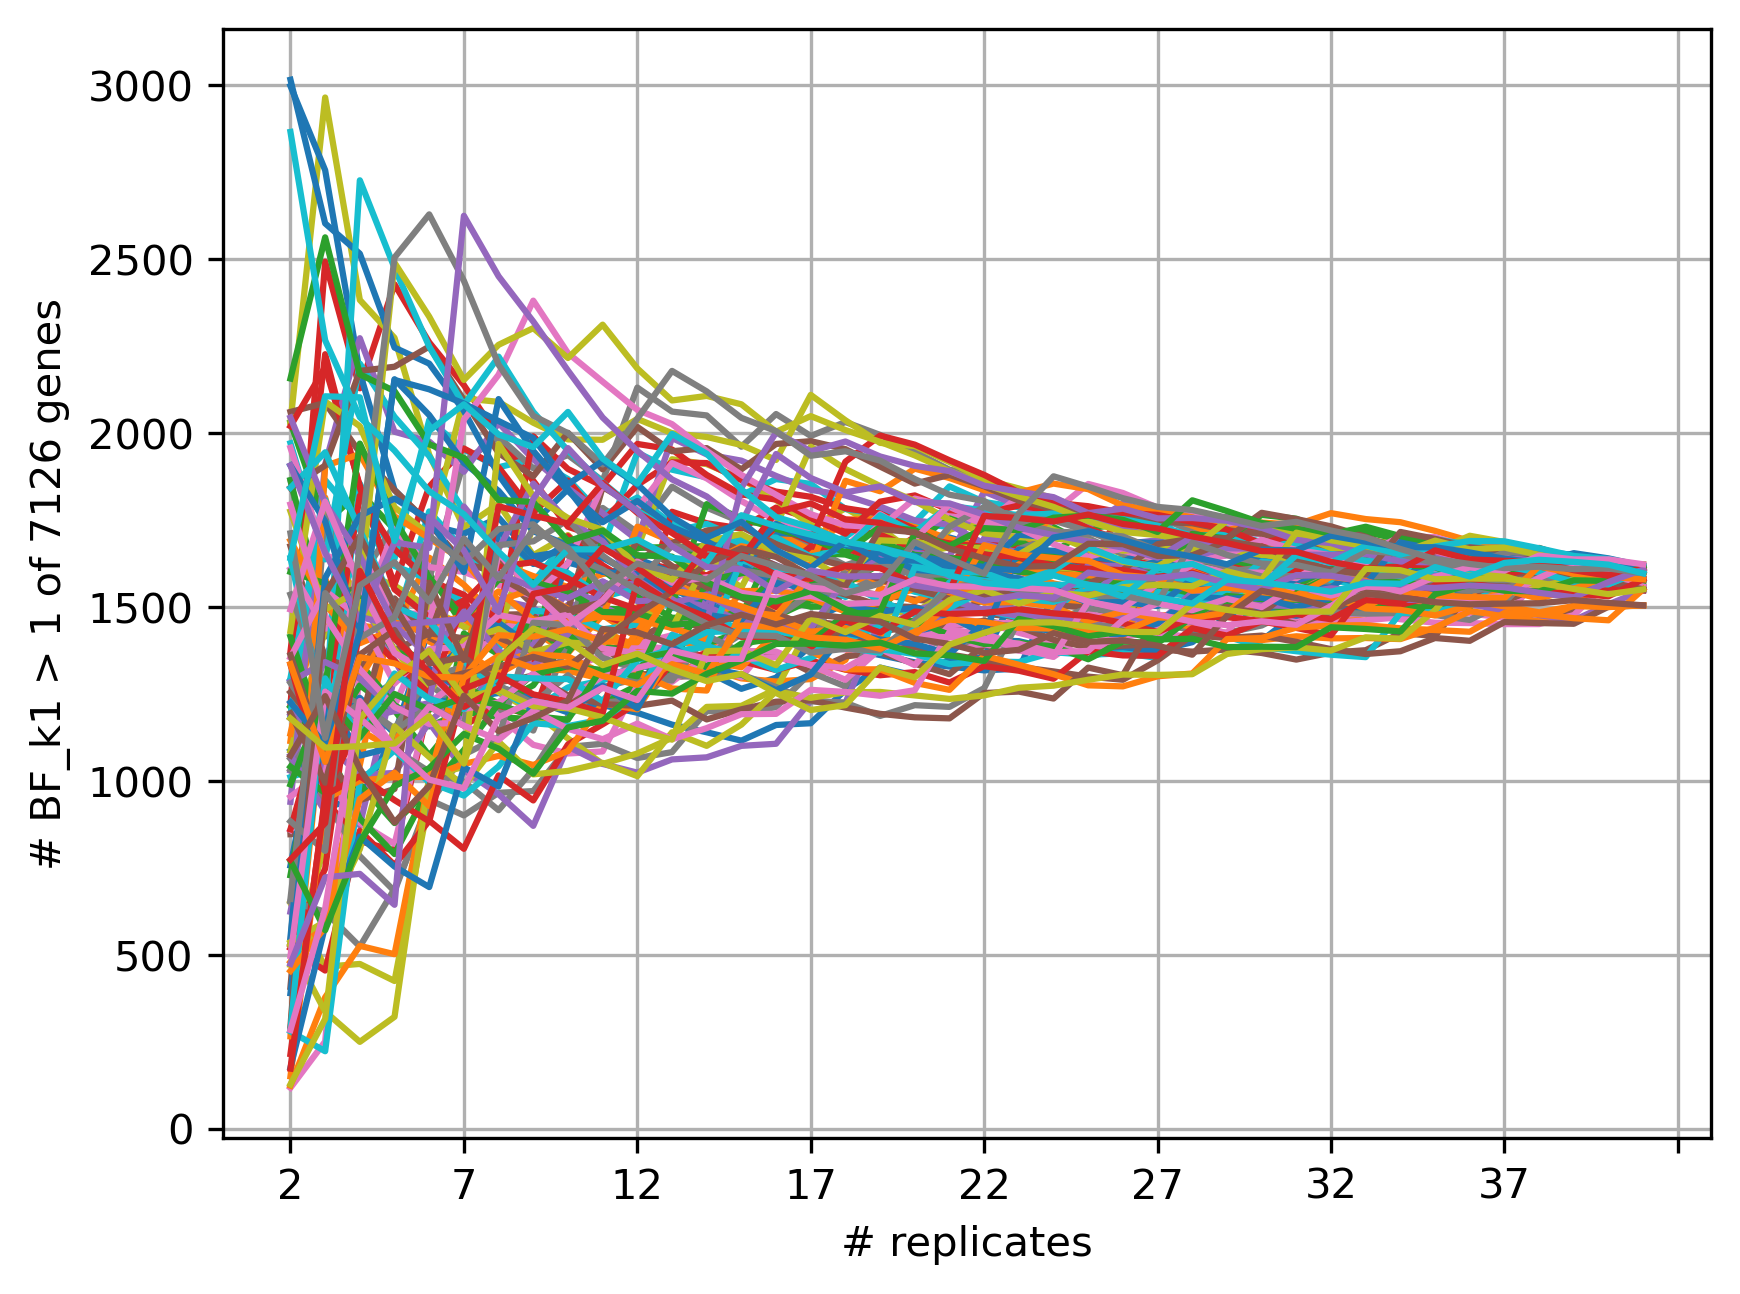

In [9]:
# then bootstrapping this idea
# 100 times for identifying genes

WT_cons_it = pd.DataFrame({})
WT_AOTP = []

for i in range(100):

    col_order = np.array(WT_yeast.columns[1:])
    np.random.shuffle(col_order)
    # print(col_order)

    cumu_BF_k1 = get_cumu_BF(WT_yeast[col_order])
    WT_AOTP.append(WT_yeast.loc[(cumu_BF_k1).iloc[:,-1] > 1].index)

    WT_cons_it[f'{i+1}'] = ((cumu_BF_k1) > 1).sum()

display(WT_cons_it)

display(WT_cons_it.plot(legend=False, grid=True,
                        xlabel='# replicates',
                        ylabel='# BF_k1 > 1 of 7126 genes'
                        ))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2,592,144,1921,1282,1985,165,434,505,970,277,209,238,1974,501,431,476,883,542,382,816
3,511,407,1493,1162,1607,751,544,1292,715,1306,501,599,1433,547,379,663,745,614,558,696
4,407,426,1833,1331,1376,1567,633,1141,1421,1067,670,1152,1059,628,814,511,655,677,553,642
5,373,421,1517,1239,1113,1418,1148,975,1626,910,1111,1137,824,637,916,832,869,672,639,934
6,407,430,1404,1094,979,1190,971,1009,1729,1156,1207,1175,978,682,935,749,824,598,626,975
7,468,488,1390,1007,884,1051,855,934,1676,1042,1059,1018,1133,756,892,784,809,673,600,1011
8,488,505,1324,912,850,1025,809,939,1468,994,947,983,1139,732,820,787,774,963,562,1156
9,583,487,1224,892,861,930,828,866,1402,936,889,889,1101,797,951,728,770,866,588,1056
10,709,471,1199,867,1115,880,772,877,1280,914,904,869,1112,828,859,715,807,957,576,993
11,658,480,1187,861,1017,817,746,982,1177,910,885,830,1064,810,988,677,825,983,557,950


<Axes: xlabel='# replicates', ylabel='# BF_k1 > 1 of 7126 genes'>

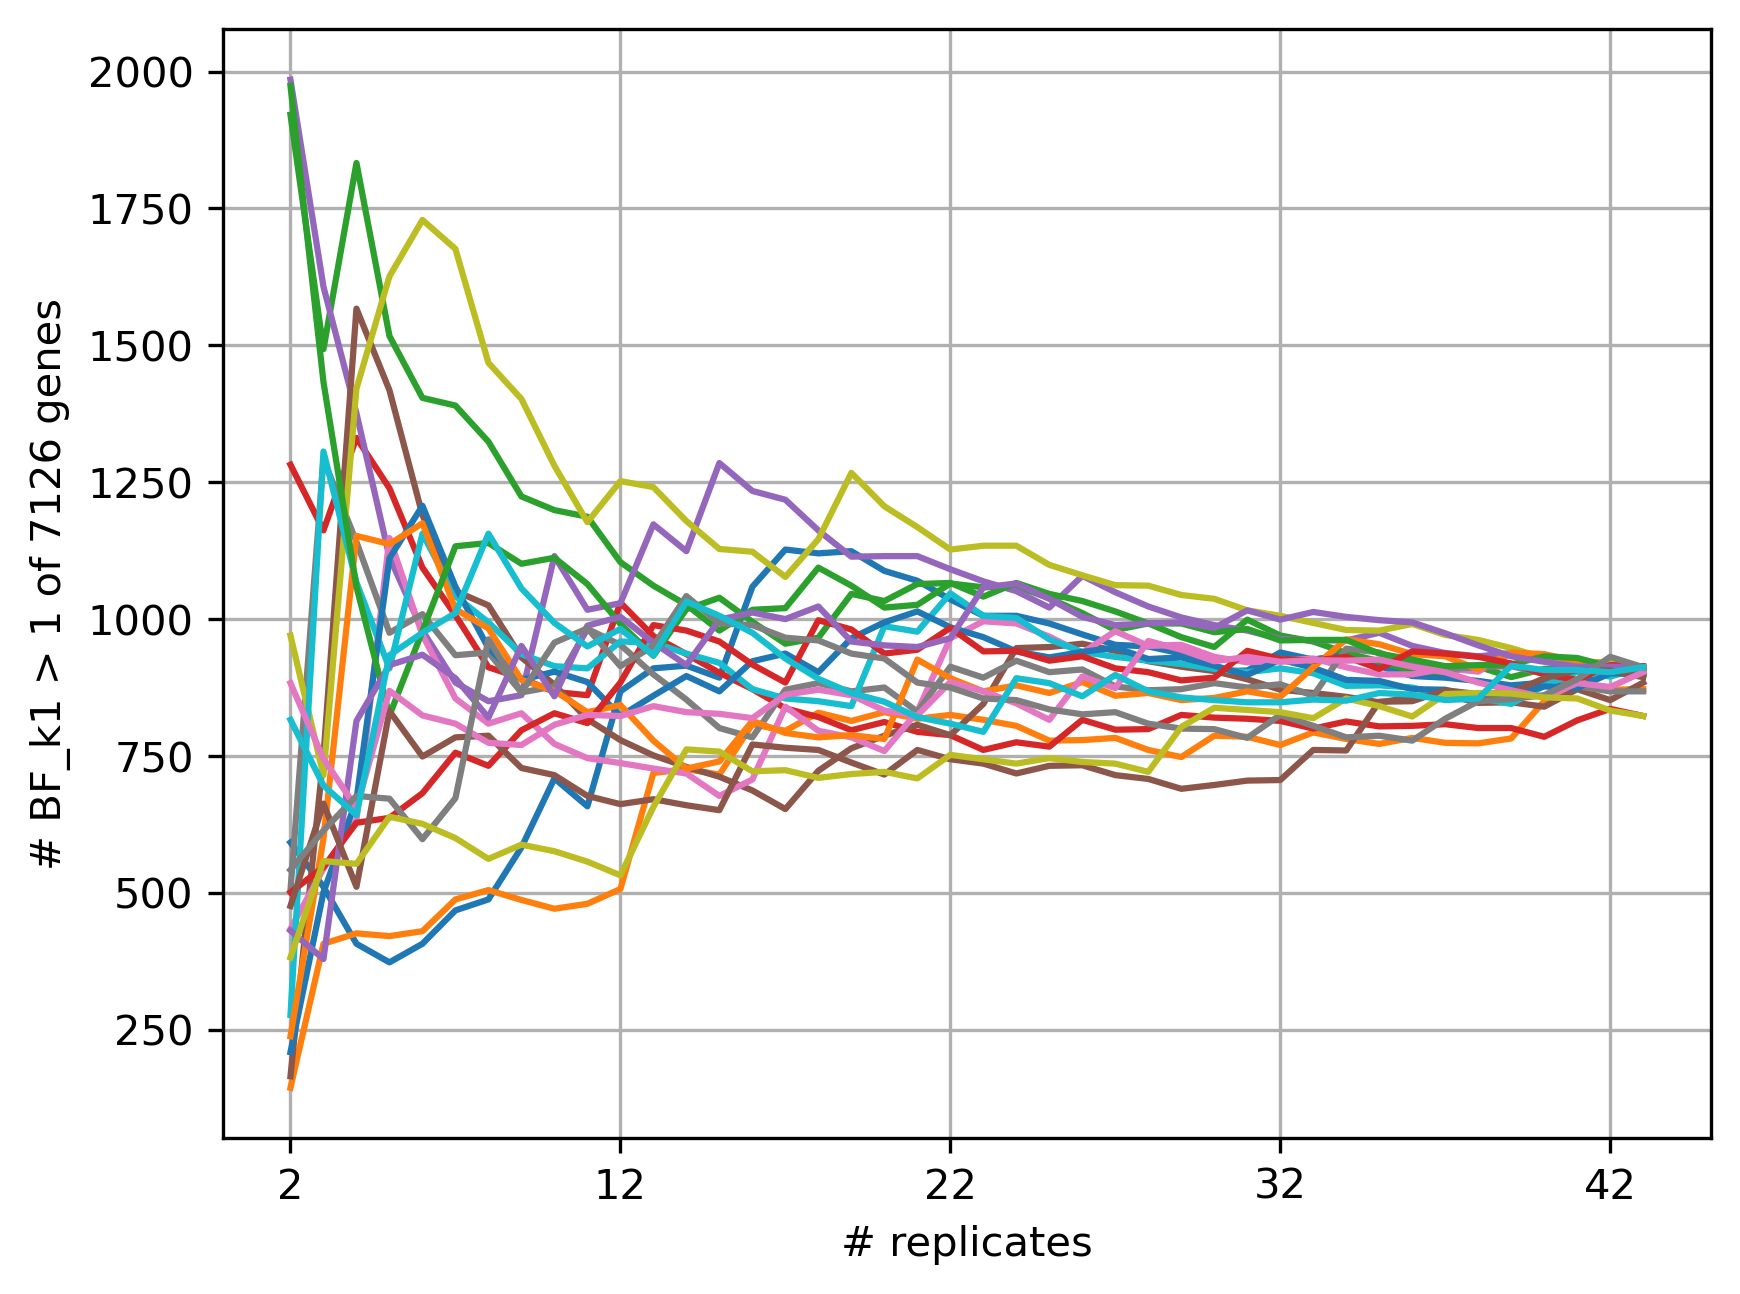

In [10]:
# again, bootstrapping this idea but on the mutant

Snf2_cons_it = pd.DataFrame({})
# Snf2_AOTP = []
# lets do this with more iterations

for i in range(20):

    col_order = np.array(Snf2_yeast.columns[1:])
    np.random.shuffle(col_order)
    # print(col_order)

    cumu_BF_k1 = get_cumu_BF(Snf2_yeast[col_order])
    # Snf2_AOTP.append(Snf2_yeast.loc[(cumu_BF_k1).iloc[:,-1] > 1].index)

    Snf2_cons_it[f'{i+1}'] = ((cumu_BF_k1) > 1).sum()

display(Snf2_cons_it)

display(Snf2_cons_it.plot(legend=False, grid=True,
                        xlabel='# replicates',
                        ylabel='# BF_k1 > 1 of 7126 genes'
                        ))

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
2,471,394,434,737,303,394,699,599,567,663,...,1340,940,437,743,524,423,745,1211,2088,907
3,495,697,357,693,376,415,1148,702,904,718,...,800,1568,417,1428,557,490,829,880,1931,1227
4,601,735,467,623,590,720,978,1046,664,778,...,1269,1465,559,1216,617,439,827,728,1556,1429
5,575,928,463,626,576,876,1060,1076,625,656,...,1196,1457,620,1278,1000,681,758,665,1513,1184
6,608,1113,494,617,542,747,935,932,898,700,...,1112,1322,978,1187,1158,686,740,709,1282,1090
7,621,999,463,639,596,784,890,838,804,665,...,1256,1179,1382,1175,1033,659,649,714,1243,1011
8,630,996,661,609,596,1024,810,794,731,758,...,1105,1104,1306,1100,932,629,637,690,1218,1037
9,841,928,904,589,582,973,835,836,730,742,...,1067,1117,1244,1002,869,672,658,683,1317,1041
10,818,900,825,577,584,904,829,775,1087,725,...,1055,1023,1203,933,815,704,750,1095,1252,990
11,768,875,811,545,743,919,820,853,1080,682,...,1009,976,1145,890,785,833,714,1059,1193,1021


<Axes: xlabel='# replicates', ylabel='# BF_k1 > 1 of 7126 genes'>

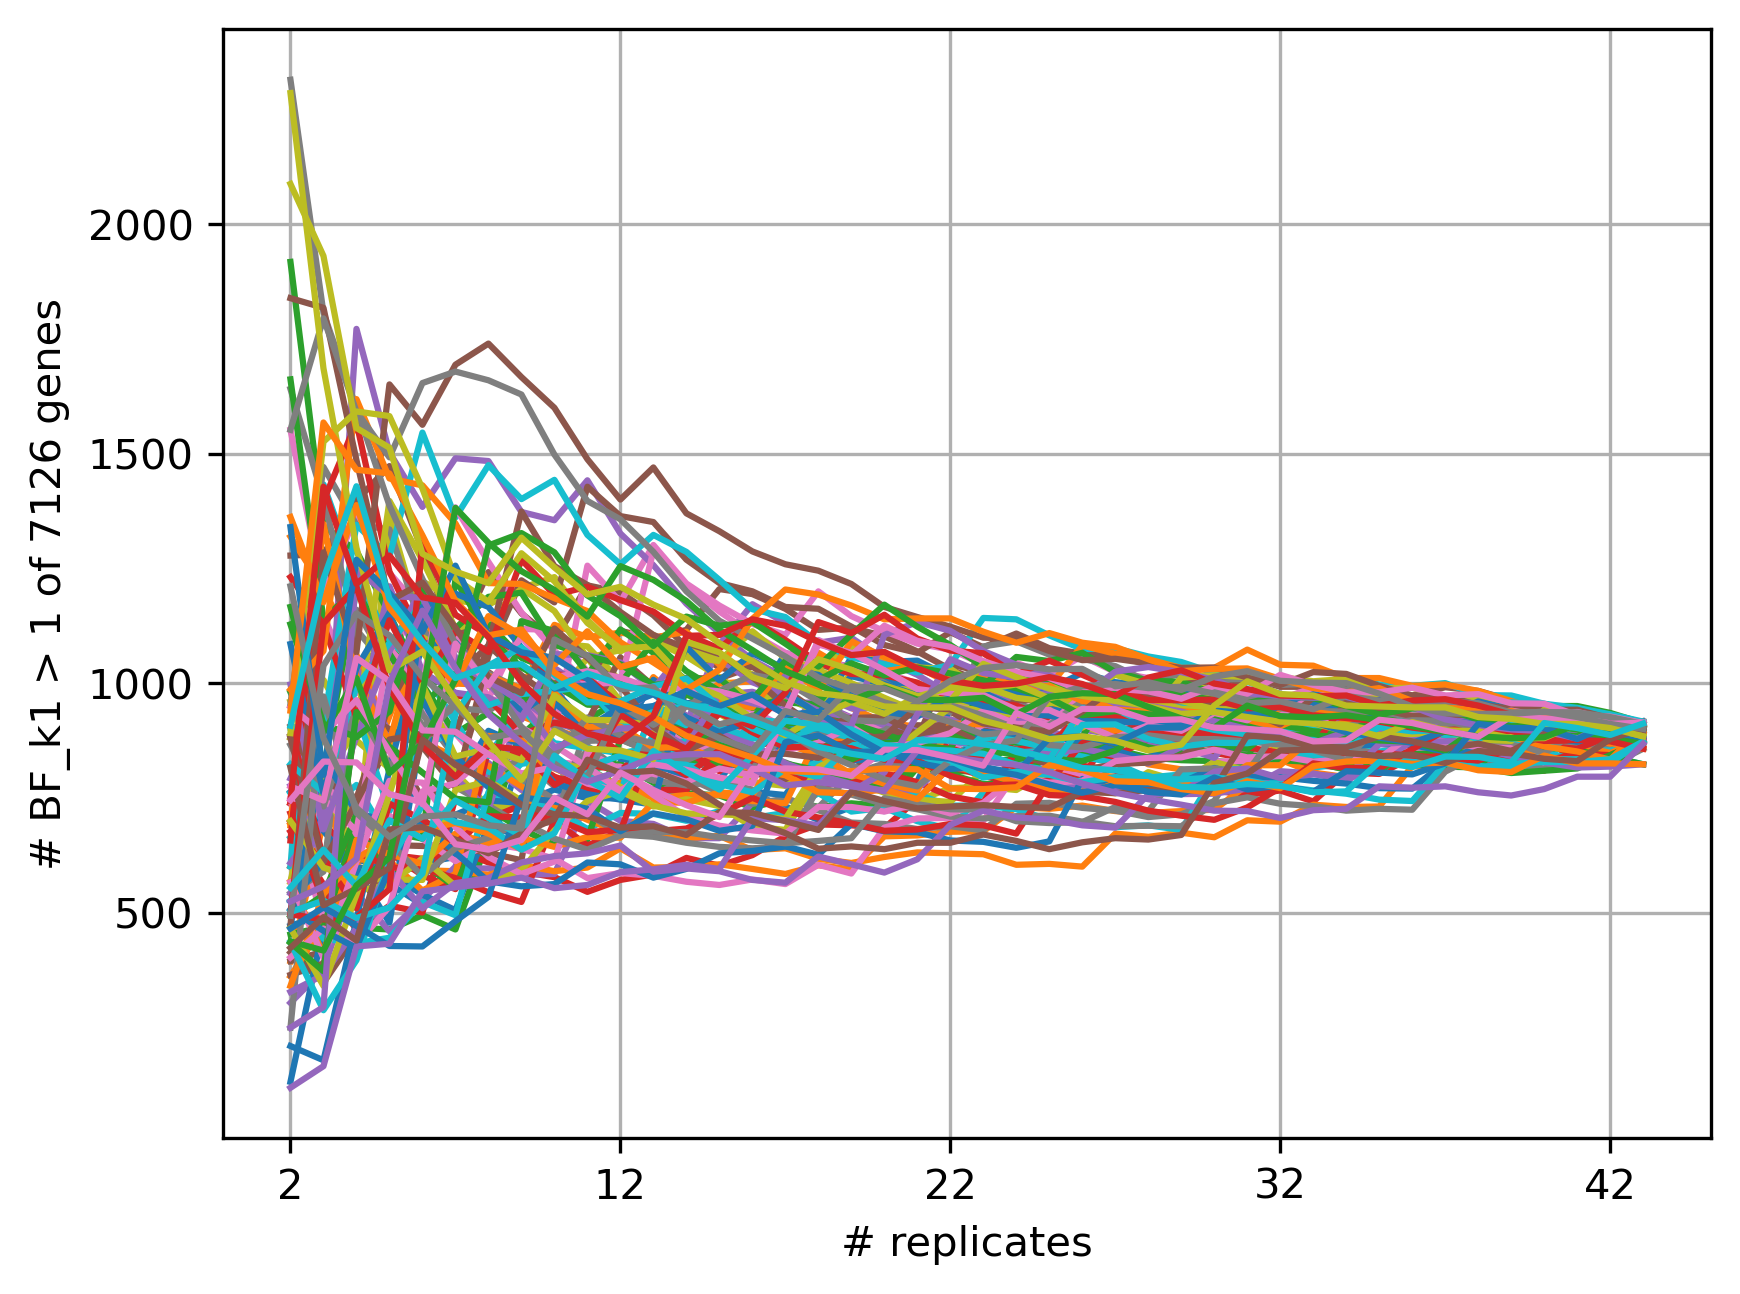

In [11]:
# again, bootstrapping this idea but on the mutant

Snf2_cons_it = pd.DataFrame({})
Snf2_AOTP = []

for i in range(100):

    col_order = np.array(Snf2_yeast.columns[1:])
    np.random.shuffle(col_order)
    # print(col_order)

    cumu_BF_k1 = get_cumu_BF(Snf2_yeast[col_order])
    Snf2_AOTP.append(Snf2_yeast.loc[(cumu_BF_k1).iloc[:,-1] > 1].index)

    Snf2_cons_it[f'{i+1}'] = ((cumu_BF_k1) > 1).sum()

display(Snf2_cons_it)

display(Snf2_cons_it.plot(legend=False, grid=True,
                        xlabel='# replicates',
                        ylabel='# BF_k1 > 1 of 7126 genes'
                        ))

In [12]:
# Checking for overlaps in Snf2_AOTP

# Convert each inner list to a set
sets = [set(lst) for lst in Snf2_AOTP]

print('# genes with BF_k1 > 1 for all replicates throughout the iterations')
for lst in Snf2_AOTP:
    print(len(lst))

# Find the intersection of all sets
Snf2_overlap = set.intersection(*sets)

# Print the Snf2_overlap
print('overlap: ', len(Snf2_overlap))
# print(Snf2_overlap)


# Find the union of all sets
Snf2_union = set.union(*sets)

# Print the union
# print(Snf2_union)
print('union: ', len(Snf2_union))


# genes with BF_k1 > 1 for all replicates throughout the iterations
884
868
911
897
912
899
912
912
901
823
912
857
913
913
912
910
895
857
907
895
895
857
823
874
912
912
868
912
912
900
916
906
895
879
910
901
912
915
906
913
912
912
874
889
823
914
912
907
912
874
907
874
905
874
884
916
873
868
901
916
911
895
910
868
873
910
898
912
912
905
900
905
907
874
911
910
911
899
903
912
879
889
868
857
910
894
913
911
884
873
901
823
903
907
868
902
914
900
884
912
overlap:  759
union:  922


In [13]:
# Checking for overlaps in WT_AOTP

# Convert each inner list to a set
sets = [set(lst) for lst in WT_AOTP]

print('# genes with BF_k1 > 1 for all replicates throughout the iterations')
for lst in WT_AOTP:
    print(len(lst))

# Find the intersection of all sets
WT_overlap = set.intersection(*sets)

# Print the WT_overlap
print('overlap: ', len(WT_overlap))
# print(WT_overlap)


# Find the union of all sets
WT_union = set.union(*sets)

# Print the union
# print(WT_union)
print('union: ', len(WT_union))


# genes with BF_k1 > 1 for all replicates throughout the iterations
1557
1596
1559
1602
1610
1608
1548
1614
1608
1618
1618
1612
1608
1613
1610
1617
1572
1605
1551
1610
1611
1505
1606
1618
1551
1572
1557
1613
1605
1594
1608
1602
1610
1603
1605
1572
1608
1612
1611
1548
1617
1617
1572
1597
1618
1581
1603
1614
1604
1602
1602
1601
1596
1596
1548
1505
1559
1611
1610
1613
1612
1505
1608
1548
1608
1608
1610
1611
1596
1608
1617
1551
1597
1581
1618
1551
1612
1611
1608
1604
1606
1613
1611
1580
1611
1611
1606
1602
1623
1618
1613
1580
1617
1611
1608
1505
1623
1597
1551
1597
overlap:  1412
union:  1633


In [14]:
RALL_bayexpress = pd.read_csv('DGE_results/RALL_bayexpress.csv').iloc[:,1:].rename(columns={'genes': "locus_name"})

RALL_bayexpress

,locus_name,BF_21,FC
0,15S_rRNA,-3.710645,0.274047
1,21S_rRNA,-1.302642,0.147177
2,HRA1,-5.206545,-0.564787
3,ICR1,76.746125,0.504048
4,LSR1,0.451012,0.120243
...,...,...,...
7121,tY(GUA)J2,-7.312143,0.861839
7122,tY(GUA)M1,-7.406574,0.022303
7123,tY(GUA)M2,-7.727890,0.183767
7124,tY(GUA)O,-7.622253,0.347266


In [15]:
# let's see what those AOTP genes are

display(RALL_bayexpress.iloc[list(WT_union)])
display(RALL_bayexpress.iloc[list(Snf2_union)])

# hmm interesting

,locus_name,BF_21,FC
1,21S_rRNA,-1.302642,0.147177
4,LSR1,0.451012,0.120243
41,RDN5-1,13.774601,0.316040
46,RDN5-6,15.230943,0.469612
56,RUF5-1,-1.191579,0.080133
...,...,...,...
6731,YPR191W,218.989419,0.279871
6745,YPR204W,814.266672,0.541523
6752,snR17a,7.383833,0.329308
6761,snR30,20.556922,0.159709


,locus_name,BF_21,FC
0,15S_rRNA,-3.710645,0.274047
1,21S_rRNA,-1.302642,0.147177
4,LSR1,0.451012,0.120243
4100,YLL021W,891.706282,0.521375
4103,YLL024C,9077.546061,-0.490986
...,...,...,...
4063,YKR094C,158.639355,-0.086969
4064,YKR095W,1141.755429,0.533953
4068,YKR098C,843.035626,0.732050
4085,YLL008W,1202.946112,-0.845752


In [16]:
# let's see what AOTP genes have BF_21 > 1

display(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF_21 > 1])
display(RALL_bayexpress.iloc[list(Snf2_union)].loc[RALL_bayexpress.BF_21 > 1])

# hmm interesting

,locus_name,BF_21,FC
41,RDN5-1,13.774601,0.316040
46,RDN5-6,15.230943,0.469612
58,SCR1,10.530223,0.125605
59,SRG1,365.733360,-0.939803
60,TLC1,777.763124,0.472738
...,...,...,...
6731,YPR191W,218.989419,0.279871
6745,YPR204W,814.266672,0.541523
6752,snR17a,7.383833,0.329308
6761,snR30,20.556922,0.159709


,locus_name,BF_21,FC
4100,YLL021W,891.706282,0.521375
4103,YLL024C,9077.546061,-0.490986
4105,YLL026W,6986.693811,-0.641283
4118,YLL039C,533.296466,0.257212
4120,YLL041C,3.231386,0.060734
...,...,...,...
4060,YKR091W,757.902699,-0.557891
4063,YKR094C,158.639355,-0.086969
4064,YKR095W,1141.755429,0.533953
4068,YKR098C,843.035626,0.732050


In [17]:
# calculating average <q> for each additional replicate for the plots


def get_avq(data):
    output = pd.DataFrame({'genes': data.genes})
    for k in range(2,len(data.columns)):

        N = sum(data.iloc[:,1:k].sum(axis=0, numeric_only=True))

        n_i = data.iloc[:,1:k].sum(axis=1, numeric_only=True)
        
        output[f'{k-1}'] = (n_i + 1) / (N+2)

    return output


# WT_yeast = get_BF_21(WT_yeast)

# display(WT_yeast)

# Snf2_yeast = get_BF_21(Snf2_yeast)

# display(Snf2_yeast)

WT_yeast_avq = get_avq(WT_yeast)

display(WT_yeast_avq)


Snf2_yeast_avq = get_avq(Snf2_yeast)

display(Snf2_yeast_avq)


WT_yeast_avq.to_csv('WT_yeast_avq.csv')
Snf2_yeast_avq.to_csv('Snf2_yeast_avq.csv')

,genes,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,15S_rRNA,5.030082e-07,1.082671e-06,2.266838e-06,1.757651e-06,1.936241e-06,1.611843e-06,1.414441e-06,1.262933e-06,1.211224e-06,...,1.904640e-06,1.853748e-06,1.946728e-06,1.911901e-06,1.879292e-06,1.874652e-06,1.864698e-06,1.802844e-06,1.838121e-06,1.808986e-06
1,21S_rRNA,3.521057e-06,7.001270e-06,9.757261e-06,9.667083e-06,1.097203e-05,9.352440e-06,8.599160e-06,7.869044e-06,7.712282e-06,...,1.143895e-05,1.116937e-05,1.165616e-05,1.143130e-05,1.125617e-05,1.124791e-05,1.114460e-05,1.082007e-05,1.111147e-05,1.103367e-05
2,HRA1,6.706775e-07,4.330683e-07,3.942327e-07,3.254910e-07,3.356151e-07,3.373626e-07,3.536103e-07,3.053245e-07,3.213451e-07,...,3.409082e-07,3.498319e-07,3.457776e-07,3.543033e-07,3.621552e-07,3.608785e-07,3.579971e-07,3.515545e-07,3.605317e-07,3.538079e-07
3,ICR1,1.274287e-05,1.436343e-05,1.507940e-05,1.507023e-05,1.448308e-05,1.510635e-05,1.486771e-05,1.450291e-05,1.438637e-05,...,1.402170e-05,1.395360e-05,1.399016e-05,1.398161e-05,1.403270e-05,1.409661e-05,1.399302e-05,1.393298e-05,1.398095e-05,1.403248e-05
4,LSR1,1.022783e-05,1.616788e-05,2.252055e-05,2.018044e-05,2.098885e-05,2.226593e-05,2.221316e-05,2.034571e-05,2.072676e-05,...,2.320770e-05,2.282563e-05,2.321551e-05,2.321690e-05,2.314857e-05,2.302277e-05,2.269390e-05,2.223207e-05,2.225545e-05,2.218147e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,tY(GUA)J2,1.676694e-07,1.443561e-07,9.855819e-08,6.509820e-08,5.163308e-08,7.496946e-08,6.429279e-08,5.551354e-08,4.943770e-08,...,1.852762e-08,1.803257e-08,1.728888e-08,1.671242e-08,1.631330e-08,1.596807e-08,1.556509e-08,1.502370e-08,1.477589e-08,1.426645e-08
7122,tY(GUA)M1,1.676694e-07,7.217804e-08,9.855819e-08,9.764730e-08,1.032662e-07,9.371182e-08,8.036599e-08,6.939192e-08,7.415655e-08,...,4.817182e-08,4.688468e-08,4.840887e-08,5.013727e-08,4.893989e-08,5.109783e-08,4.980829e-08,4.807583e-08,4.728285e-08,4.850592e-08
7123,tY(GUA)M2,1.676694e-07,7.217804e-08,9.855819e-08,6.509820e-08,5.163308e-08,3.748473e-08,4.821959e-08,4.163515e-08,3.707828e-08,...,1.482210e-08,1.442606e-08,1.383111e-08,1.336994e-08,1.305064e-08,1.277446e-08,1.245207e-08,1.201896e-08,1.182071e-08,1.141316e-08
7124,tY(GUA)O,1.676694e-07,7.217804e-08,4.927909e-08,3.254910e-08,2.581654e-08,1.874236e-08,3.214639e-08,2.775677e-08,2.471885e-08,...,1.111657e-08,1.081954e-08,1.037333e-08,1.336994e-08,1.305064e-08,1.277446e-08,1.245207e-08,1.201896e-08,1.182071e-08,1.141316e-08


,genes,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,15S_rRNA,4.888009e-07,3.699162e-07,4.332702e-07,4.431870e-07,1.392500e-06,1.178058e-06,1.093068e-06,9.750276e-07,1.354988e-06,...,2.247482e-06,2.162239e-06,2.153404e-06,2.107489e-06,2.068077e-06,2.252873e-06,2.219721e-06,2.264491e-06,2.219710e-06,2.184992e-06
1,21S_rRNA,3.128326e-06,2.642259e-06,2.635727e-06,3.050169e-06,1.045480e-05,8.800790e-06,8.213191e-06,7.299531e-06,8.343876e-06,...,1.195357e-05,1.158432e-05,1.153281e-05,1.139055e-05,1.119966e-05,1.252824e-05,1.236465e-05,1.273472e-05,1.249908e-05,1.232996e-05
2,HRA1,5.865611e-07,3.699162e-07,3.610585e-07,2.867680e-07,2.873412e-07,2.425414e-07,2.732670e-07,2.898731e-07,2.614890e-07,...,2.475201e-07,2.514231e-07,2.603689e-07,2.526609e-07,2.534122e-07,2.465408e-07,2.432571e-07,2.434937e-07,2.431111e-07,2.376114e-07
3,ICR1,2.013860e-05,2.124376e-05,2.213289e-05,2.255039e-05,2.192635e-05,2.195000e-05,2.166400e-05,2.130567e-05,2.095478e-05,...,1.977850e-05,1.973357e-05,1.970839e-05,1.967188e-05,1.975450e-05,1.979128e-05,1.981993e-05,1.979874e-05,1.982148e-05,1.987671e-05
4,LSR1,2.062740e-05,1.659338e-05,1.707807e-05,1.910918e-05,2.278837e-05,2.311074e-05,2.170954e-05,2.058099e-05,2.169170e-05,...,2.351111e-05,2.317493e-05,2.318508e-05,2.295350e-05,2.265855e-05,2.414683e-05,2.418197e-05,2.428173e-05,2.402572e-05,2.406074e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,tY(GUA)J2,1.955204e-07,1.056903e-07,7.221170e-08,5.213964e-08,4.420634e-08,3.464878e-08,4.554450e-08,3.952815e-08,3.565759e-08,...,1.320107e-08,1.571395e-08,1.837898e-08,1.783489e-08,1.747671e-08,1.700282e-08,1.658571e-08,1.623291e-08,2.114009e-08,2.324459e-08
7122,tY(GUA)M1,9.776019e-08,5.284517e-08,7.221170e-08,5.213964e-08,8.841268e-08,6.929756e-08,6.072600e-08,5.270420e-08,4.754345e-08,...,4.950401e-08,5.028463e-08,5.207378e-08,5.350466e-08,5.243012e-08,5.100845e-08,4.975714e-08,4.869873e-08,4.756521e-08,4.648918e-08
7123,tY(GUA)M2,9.776019e-08,5.284517e-08,3.610585e-08,2.606982e-08,2.210317e-08,1.732439e-08,1.518150e-08,1.317605e-08,1.188586e-08,...,1.650134e-08,1.571395e-08,1.531582e-08,1.486241e-08,1.456392e-08,1.416901e-08,1.382143e-08,1.352743e-08,1.321256e-08,1.291366e-08
7124,tY(GUA)O,9.776019e-08,1.056903e-07,7.221170e-08,5.213964e-08,4.420634e-08,3.464878e-08,3.036300e-08,2.635210e-08,3.565759e-08,...,1.980160e-08,1.885673e-08,2.144214e-08,2.080737e-08,2.038949e-08,1.983662e-08,1.935000e-08,1.893840e-08,1.849758e-08,1.807913e-08


In [18]:
RALL_bayexpress['BF_k1_WT'] = get_BF_k1(WT_yeast.iloc[:,1:])
RALL_bayexpress['AOTP_WT'] = RALL_bayexpress.index.isin(WT_union)

RALL_bayexpress['BF_k1_Snf2'] = get_BF_k1(Snf2_yeast.iloc[:,1:])
RALL_bayexpress['AOTP_Snf2'] = RALL_bayexpress.index.isin(Snf2_union)

display(RALL_bayexpress)
RALL_bayexpress.to_csv('RALL_bayexpress.csv')

,locus_name,BF_21,FC,BF_k1_WT,AOTP_WT,BF_k1_Snf2,AOTP_Snf2
0,15S_rRNA,-3.710645,0.274047,-107.138056,False,53.627445,True
1,21S_rRNA,-1.302642,0.147177,362.115507,True,1052.203968,True
2,HRA1,-5.206545,-0.564787,-240.338654,False,-258.581365,False
3,ICR1,76.746125,0.504048,-194.077441,False,-196.467262,False
4,LSR1,0.451012,0.120243,251.787125,True,478.066414,True
...,...,...,...,...,...,...,...
7121,tY(GUA)J2,-7.312143,0.861839,-270.299503,False,-281.214963,False
7122,tY(GUA)M1,-7.406574,0.022303,-262.736078,False,-275.253246,False
7123,tY(GUA)M2,-7.727890,0.183767,-271.177492,False,-284.863866,False
7124,tY(GUA)O,-7.622253,0.347266,-270.291196,False,-282.682788,False


# How many genes would be marked as not consistent?

In [19]:
display((RALL_bayexpress.BF_k1_WT > 1).describe())

display((RALL_bayexpress.BF_k1_Snf2 > 1).describe())

display(((RALL_bayexpress.BF_k1_WT > 1) & (RALL_bayexpress.BF_k1_Snf2 > 1)).describe())

display(((RALL_bayexpress.BF_k1_WT > 1) | (RALL_bayexpress.BF_k1_Snf2 > 1)).describe())



count      7126
unique        2
top       False
freq       5524
Name: BF_k1_WT, dtype: object

count      7126
unique        2
top       False
freq       6223
Name: BF_k1_Snf2, dtype: object

count      7126
unique        2
top       False
freq       6359
dtype: object

count      7126
unique        2
top       False
freq       5388
dtype: object

In [20]:
WT_yeast_q = pd.DataFrame({})

for col in WT_yeast.columns[1:43]:

    WT_yeast_q[col+'_q'] = (WT_yeast[col]+1) / (sum(WT_yeast[col])+2)

WT_yeast_q.to_csv('WT_yeast_q.csv')

WT_yeast_q

,8_q,31_q,15_q,3_q,14_q,4_q,39_q,30_q,21_q,29_q,...,12_q,37_q,34_q,26_q,13_q,32_q,22_q,35_q,19_q,7_q
0,4.065404e-07,1.816573e-07,5.250010e-07,4.970523e-06,1.353193e-06,8.628760e-07,1.727728e-07,3.455352e-06,2.093998e-06,1.578264e-06,...,3.652909e-07,1.810945e-06,4.192114e-06,1.211476e-06,1.651220e-06,1.528210e-06,7.542872e-07,1.002461e-06,2.573225e-06,3.385883e-07
1,3.353958e-06,2.724860e-06,2.756255e-06,1.584354e-05,7.910972e-06,9.587511e-06,1.900501e-06,1.307024e-05,1.439624e-05,1.167915e-05,...,1.461164e-06,1.101658e-05,2.305663e-05,5.365107e-06,4.513335e-06,1.000283e-05,5.908583e-06,5.012305e-06,9.649594e-06,4.175923e-06
2,1.016351e-07,4.541433e-07,1.312503e-07,4.659866e-07,5.204587e-07,2.876253e-07,2.591592e-07,4.506981e-07,6.543744e-07,6.313054e-07,...,8.523455e-07,4.527362e-07,3.353691e-07,3.461360e-07,3.302440e-07,2.778564e-07,7.542872e-07,7.017227e-07,4.288709e-07,5.643139e-07
3,1.229785e-05,1.017281e-05,1.509378e-05,1.677552e-05,1.634240e-05,1.514827e-05,1.235325e-05,1.442234e-05,1.518149e-05,1.188959e-05,...,1.205460e-05,1.720398e-05,1.492393e-05,1.618186e-05,1.398033e-05,9.030333e-06,1.470860e-05,1.383396e-05,1.275891e-05,1.354353e-05
4,8.638984e-06,9.173695e-06,1.312503e-05,3.634695e-05,1.374011e-05,1.572352e-05,9.502503e-06,3.365212e-05,2.970860e-05,2.788266e-05,...,1.692515e-05,1.735489e-05,3.236312e-05,1.540305e-05,2.201627e-05,7.779979e-06,1.760003e-05,2.335734e-05,1.254447e-05,2.200824e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,1.016351e-07,9.082867e-08,1.312503e-07,1.553289e-07,1.040917e-07,9.587511e-08,8.638639e-08,1.502327e-07,1.308749e-07,1.052176e-07,...,1.217636e-07,1.509121e-07,8.384228e-08,8.653399e-08,1.100813e-07,1.389282e-07,1.257145e-07,1.002461e-07,1.072177e-07,1.128628e-07
7122,1.016351e-07,9.082867e-08,1.312503e-07,3.106577e-07,1.040917e-07,1.917502e-07,8.638639e-08,1.502327e-07,2.617497e-07,1.052176e-07,...,1.217636e-07,3.018241e-07,1.676846e-07,8.653399e-08,1.100813e-07,1.389282e-07,2.514291e-07,2.004922e-07,1.072177e-07,1.128628e-07
7123,1.016351e-07,9.082867e-08,1.312503e-07,3.106577e-07,1.040917e-07,9.587511e-08,8.638639e-08,1.502327e-07,1.308749e-07,1.052176e-07,...,1.217636e-07,1.509121e-07,8.384228e-08,8.653399e-08,1.100813e-07,1.389282e-07,1.257145e-07,1.002461e-07,1.072177e-07,2.257256e-07
7124,1.016351e-07,9.082867e-08,1.312503e-07,1.553289e-07,1.040917e-07,9.587511e-08,8.638639e-08,1.502327e-07,1.308749e-07,1.052176e-07,...,1.217636e-07,1.509121e-07,8.384228e-08,8.653399e-08,1.100813e-07,1.389282e-07,2.514291e-07,2.004922e-07,1.072177e-07,2.257256e-07


In [21]:
Snf2_yeast_q = pd.DataFrame({})

for col in Snf2_yeast.columns[1:43]:

    Snf2_yeast_q[col+'_q'] = (Snf2_yeast[col]+1) / (sum(Snf2_yeast[col])+2)

Snf2_yeast_q.to_csv('Snf2_yeast_q.csv')

Snf2_yeast_q

,38_q,41_q,37_q,12_q,9_q,27_q,19_q,30_q,22_q,26_q,...,14_q,36_q,40_q,28_q,3_q,6_q,8_q,39_q,13_q,15_q
0,2.900728e-07,4.451590e-06,7.028538e-07,2.240068e-05,4.976768e-06,4.152554e-06,2.203145e-06,1.443493e-06,7.894240e-06,9.023679e-07,...,6.612430e-07,1.934424e-06,1.014152e-06,7.889508e-07,6.839056e-07,4.807801e-07,2.992327e-07,8.987743e-06,9.497976e-07,5.007454e-06
1,2.030510e-06,2.988925e-05,6.827723e-06,8.024281e-05,1.808630e-05,2.366956e-05,9.337138e-06,6.538174e-06,3.114636e-05,7.863492e-06,...,4.298080e-06,9.672119e-06,5.972229e-06,6.048623e-06,2.735623e-06,2.884681e-06,1.396419e-06,6.030148e-05,4.748988e-06,3.848866e-05
2,4.351093e-07,3.815649e-07,1.004077e-07,2.103350e-07,1.213846e-07,2.768369e-07,6.294700e-07,3.396454e-07,4.305949e-07,2.578194e-07,...,3.306215e-07,7.254089e-07,2.253671e-07,6.574590e-07,4.559371e-07,1.602600e-07,4.987212e-07,1.045086e-07,2.374494e-07,2.945561e-07
3,2.393101e-05,1.895106e-05,1.857542e-05,2.187484e-05,1.784353e-05,1.716389e-05,1.982830e-05,2.037873e-05,1.901794e-05,2.797341e-05,...,1.939646e-05,1.886063e-05,2.107183e-05,1.354366e-05,2.416467e-05,2.211589e-05,1.905115e-05,2.121525e-05,1.733381e-05,2.002981e-05
4,8.412112e-06,2.899893e-05,1.546278e-05,9.423009e-05,3.204553e-05,3.681931e-05,2.706721e-05,2.606779e-05,3.695939e-05,1.740281e-05,...,1.520859e-05,2.369669e-05,2.569185e-05,1.078233e-05,1.823748e-05,2.435953e-05,1.326598e-05,7.764992e-05,7.242207e-06,4.320156e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,1.450364e-07,1.271883e-07,1.004077e-07,1.051675e-07,1.213846e-07,1.384185e-07,1.049117e-07,8.491135e-08,7.176581e-08,2.578194e-07,...,1.102072e-07,2.418030e-07,1.126836e-07,1.314918e-07,1.139843e-07,8.013002e-08,9.974424e-08,1.045086e-07,1.187247e-07,9.818537e-08
7122,1.450364e-07,1.271883e-07,2.008154e-07,1.051675e-07,1.213846e-07,1.384185e-07,1.049117e-07,8.491135e-08,1.435316e-07,1.289097e-07,...,2.204143e-07,2.418030e-07,1.126836e-07,2.629836e-07,2.279685e-07,8.013002e-08,9.974424e-08,1.045086e-07,1.187247e-07,1.963707e-07
7123,1.450364e-07,1.271883e-07,1.004077e-07,1.051675e-07,1.213846e-07,1.384185e-07,2.098233e-07,8.491135e-08,7.176581e-08,1.289097e-07,...,1.102072e-07,1.209015e-07,1.126836e-07,1.314918e-07,1.139843e-07,8.013002e-08,9.974424e-08,1.045086e-07,1.187247e-07,1.963707e-07
7124,1.450364e-07,1.271883e-07,1.004077e-07,1.051675e-07,2.427692e-07,1.384185e-07,1.049117e-07,8.491135e-08,7.176581e-08,1.289097e-07,...,1.102072e-07,2.418030e-07,1.126836e-07,1.314918e-07,1.139843e-07,8.013002e-08,9.974424e-08,1.045086e-07,1.187247e-07,9.818537e-08


In [22]:
RALL_bayexpress

,locus_name,BF_21,FC,BF_k1_WT,AOTP_WT,BF_k1_Snf2,AOTP_Snf2
0,15S_rRNA,-3.710645,0.274047,-107.138056,False,53.627445,True
1,21S_rRNA,-1.302642,0.147177,362.115507,True,1052.203968,True
2,HRA1,-5.206545,-0.564787,-240.338654,False,-258.581365,False
3,ICR1,76.746125,0.504048,-194.077441,False,-196.467262,False
4,LSR1,0.451012,0.120243,251.787125,True,478.066414,True
...,...,...,...,...,...,...,...
7121,tY(GUA)J2,-7.312143,0.861839,-270.299503,False,-281.214963,False
7122,tY(GUA)M1,-7.406574,0.022303,-262.736078,False,-275.253246,False
7123,tY(GUA)M2,-7.727890,0.183767,-271.177492,False,-284.863866,False
7124,tY(GUA)O,-7.622253,0.347266,-270.291196,False,-282.682788,False


In [23]:
# WT union AOTP genes, examples

display(WT_yeast.iloc[list(WT_union)][:5])
display(Snf2_yeast.iloc[list(WT_union)][:5])

print(list(WT_yeast.iloc[list(WT_union)][:5].genes))


,genes,8,31,15,3,14,4,39,30,21,...,12,37,34,26,13,32,22,35,19,7
1,21S_rRNA,20,76,101,99,128,74,36,32,57,...,10,274,49,30,72,58,21,159,107,70
4,LSR1,60,163,233,163,193,375,194,84,211,...,66,385,232,149,114,81,109,132,243,128
41,RDN5-1,50,42,105,48,36,80,37,50,49,...,28,184,40,48,27,107,63,17,201,29
46,RDN5-6,21,11,71,7,16,15,16,25,23,...,8,95,14,9,24,42,5,4,106,18
56,RUF5-1,159,404,313,454,457,732,297,155,247,...,138,380,326,197,554,102,318,198,351,350


,genes,38,41,37,12,9,27,19,30,22,...,40,28,3,6,8,39,13,15,11,32
1,21S_rRNA,31,18,23,44,356,35,33,13,148,...,64,79,67,13,576,52,234,23,44,24
4,LSR1,210,103,159,260,298,303,96,132,263,...,250,195,153,57,742,227,227,117,224,136
41,RDN5-1,49,40,48,79,175,77,33,34,134,...,96,103,72,36,326,50,53,43,55,58
46,RDN5-6,18,14,11,31,84,21,18,7,46,...,49,47,27,8,212,10,35,13,20,26
56,RUF5-1,472,217,267,409,291,619,301,292,196,...,499,271,366,225,376,491,385,373,541,375


['21S_rRNA', 'LSR1', 'RDN5-1', 'RDN5-6', 'RUF5-1']


In [24]:
# WT union AOTP genes, examples

# let's see what AOTP genes have BF_21 > 1

display(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF_21 > 1].sort_values(by='BF_21')[:5])

# hmm interesting

display(WT_yeast.iloc[RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF_21 > 1].sort_values(by='BF_21')[:5].index])
display(Snf2_yeast.iloc[RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF_21 > 1].sort_values(by='BF_21')[:5].index])

display(list(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF_21 > 1].sort_values(by='BF_21')[:5].locus_name))


,locus_name,BF_21,FC,BF_k1_WT,AOTP_WT,BF_k1_Snf2,AOTP_Snf2
3425,YJL098W,1.025525,-0.091190,113.153322,True,-129.167778,False
5742,YOL115W,1.025888,0.075491,57.474774,True,-151.068325,False
4515,YLR333C,1.447678,-0.029229,196.567132,True,97.113080,True
5822,YOR021C,1.559348,0.053039,92.677944,True,-118.214175,False
1540,YDR408C,2.105490,-0.049501,-6.324689,True,-62.712539,False


,genes,8,31,15,3,14,4,39,30,21,...,12,37,34,26,13,32,22,35,19,7
3425,YJL098W,191,444,189,274,482,835,377,351,333,...,425,319,600,276,190,276,740,141,675,209
5742,YOL115W,264,616,398,517,650,1168,568,430,505,...,422,490,739,394,326,292,794,277,827,350
4515,YLR333C,1998,3860,2924,4519,3708,6447,3511,3448,4006,...,3045,4715,4487,2930,2862,2345,4573,2453,5339,3408
5822,YOR021C,613,1116,776,1198,1241,2370,1216,1055,1132,...,931,1311,1572,964,616,765,1750,593,1737,959
1540,YDR408C,1267,1172,950,1814,1178,2045,1383,1651,1693,...,1096,2000,1386,1014,1127,1575,1944,888,1873,1428


,genes,38,41,37,12,9,27,19,30,22,...,40,28,3,6,8,39,13,15,11,32
3425,YJL098W,422,275,270,406,206,479,388,422,328,...,632,355,483,251,318,441,302,344,430,272
5742,YOL115W,631,462,529,677,386,884,442,632,568,...,996,523,574,420,580,568,518,596,664,599
4515,YLR333C,4120,3430,3463,4082,2873,4475,2786,4668,4097,...,5687,3221,3619,2557,4038,3758,3569,3820,3803,3577
5822,YOR021C,1312,1060,1072,1540,870,1717,1025,1434,1224,...,2116,1146,1205,805,1134,1341,1011,1206,1316,945
1540,YDR408C,1539,1440,1308,1575,1285,2026,1449,1278,1144,...,2456,1158,1872,1210,1756,1399,1320,1310,1314,1219


['YJL098W', 'YOL115W', 'YLR333C', 'YOR021C', 'YDR408C']

In [25]:
# WT union AOTP genes, examples

# let's see what AOTP genes have BF_21 > 1

display(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF_21 > 1].sort_values(by='BF_21')[-5:])

# hmm interesting

display(WT_yeast.iloc[RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF_21 > 1].sort_values(by='BF_21')[-5:].index])
display(Snf2_yeast.iloc[RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF_21 > 1].sort_values(by='BF_21')[-5:].index])

display(list(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF_21 > 1].sort_values(by='BF_21')[-5:].locus_name))


,locus_name,BF_21,FC,BF_k1_WT,AOTP_WT,BF_k1_Snf2,AOTP_Snf2
2639,YGR192C,101517.928512,-0.456369,52530.251796,True,23438.201797,True
6209,YOR383C,118338.158193,1.478789,1920.042323,True,10685.558763,True
1465,YDR342C,151255.899622,-2.643644,21822.485016,True,2076.867472,True
3012,YHR174W,205922.035360,-0.847059,13841.417356,True,7918.998188,True
1175,YDR077W,341558.582413,-3.175344,13017.391966,True,1422.483953,True


,genes,8,31,15,3,14,4,39,30,21,...,12,37,34,26,13,32,22,35,19,7
2639,YGR192C,188825,196804,172119,328674,225435,357247,261535,343455,268394,...,246621,358116,278531,209062,191739,318398,338511,169415,348635,244192
6209,YOR383C,12713,11599,10437,18694,10940,21254,11928,20445,14405,...,11286,21585,17444,12251,10503,16357,18733,8162,19044,14295
1465,YDR342C,20257,15357,26120,29846,13135,29153,16334,36916,24772,...,13346,47023,14585,25504,23590,25281,20870,22192,24641,22226
3012,YHR174W,129581,133346,109168,207147,145674,268592,196925,211933,189789,...,157763,235246,191877,136675,120124,195917,243868,107856,237778,158290
1175,YDR077W,35563,31153,31852,54048,30594,65771,39147,58449,45629,...,37196,63004,38304,36697,33838,54827,54371,26658,50782,45913


,genes,38,41,37,12,9,27,19,30,22,...,40,28,3,6,8,39,13,15,11,32
2639,YGR192C,205731,199983,210124,204494,158243,242692,209080,210681,178901,...,323457,180745,239701,163673,219417,167478,177709,170179,160083,142435
6209,YOR383C,36728,39745,40978,49945,33631,56767,31049,52374,33049,...,60183,37108,50351,34465,46750,37686,43105,47984,34235,29763
1465,YDR342C,6160,4351,3760,5849,2707,8347,4344,2973,2201,...,7219,4147,5938,2552,3313,4676,2446,2606,4178,1935
3012,YHR174W,107206,100381,112005,104187,76754,126571,101232,105342,114602,...,165739,86105,112391,81618,106975,86521,85779,95411,83560,75125
1175,YDR077W,5978,5813,4679,5852,4049,9193,4939,4684,2002,...,9285,5125,7021,4165,5594,5013,4016,3755,4674,3275


['YGR192C', 'YOR383C', 'YDR342C', 'YHR174W', 'YDR077W']

In [26]:
# Snf2 union AOTP genes, examples

display(WT_yeast.iloc[list(Snf2_union)][:5])
display(Snf2_yeast.iloc[list(Snf2_union)][:5])

print(list(Snf2_yeast.iloc[list(Snf2_union)][:5].genes))


,genes,8,31,15,3,14,4,39,30,21,...,12,37,34,26,13,32,22,35,19,7
0,15S_rRNA,2,12,31,8,21,11,2,3,7,...,0,49,9,4,11,12,1,22,12,4
1,21S_rRNA,20,76,101,99,128,74,36,32,57,...,10,274,49,30,72,58,21,159,107,70
4,LSR1,60,163,233,163,193,375,194,84,211,...,66,385,232,149,114,81,109,132,243,128
4100,YLL021W,750,1190,759,1284,1172,2758,1282,1194,1057,...,1067,1624,1648,1073,742,902,1868,606,1943,1076
4103,YLL024C,13940,16062,13989,24924,15680,28293,20802,24091,19080,...,17245,27935,22996,17317,16363,19475,24881,13493,25858,19777


,genes,38,41,37,12,9,27,19,30,22,...,40,28,3,6,8,39,13,15,11,32
0,15S_rRNA,4,2,5,5,46,5,4,2,40,...,7,15,6,1,85,8,34,3,6,3
1,21S_rRNA,31,18,23,44,356,35,33,13,148,...,64,79,67,13,576,52,234,23,44,24
4,LSR1,210,103,159,260,298,303,96,132,263,...,250,195,153,57,742,227,227,117,224,136
4100,YLL021W,1921,1652,1855,2319,1259,2869,1387,1922,1951,...,3413,1731,1890,1437,1780,1846,1514,1997,1825,1484
4103,YLL024C,14168,15026,15877,15309,11377,15925,11809,19464,17624,...,23070,12714,13424,11915,15851,12510,13526,16627,11588,12153


['15S_rRNA', '21S_rRNA', 'LSR1', 'YLL021W', 'YLL024C']


In [27]:
# exporting this table to compare with WT-WT control experiments

RALL_bayexpress.iloc[(list(WT_union))].to_csv('RALL_bayexpress_AOTP_WT_union.csv')